In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# OfflineTV who?
> A model to tell you which OfflineTV member is in the photo

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]

With our previous model, we failed to make an accurate categorical model. So, we'll have proper categories this time by having a proper objective. 

- Objective: To identify the face of the OfflineTV member in the photo and give their name.
- Levers: Categories of OfflineTV members and threshold of acceptance
- Data: use Bing Image API with queries of "[name]"

My main fear is getting the data... a lot of the data might contain more than one face and may not even be their face or may be a thumbnail for a video. But, that's what the cleaning process is for :).

So, we set our key, create a tuple for our categories and set our path. I'm sadly going to have to exclude Brodin Plett from the list because of the lack of his [photos](https://www.bing.com/images/search?q=brodin%20plett&qs=n&form=QBIR&sp=-1&pq=brodin%20plett).

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', 'KEY')
names = 'Scarra', 'Pokimane', 'LilyPichu', 'Disguised Toast Jeremy Wang', 'Yvonnie offlinetv', 'Michael Reeves'
path = Path('otv')

Now we can download the data. We'll only download 30 images of each instead of 150 because it's difficult to get relevant data through Bing (even with 30, there will be some irrelevant images):

In [ ]:
if not path.exists():
  path.mkdir()
  for o in names:
    dest = (path/o)
    dest.mkdir(exist_ok = True)
    results = search_images_bing(key, o, max_images = 30)
    download_images(dest, urls = results.attrgot('contentUrl'))

In [ ]:
# Check they were all downloaded properly
fns = get_image_files(path)
fns

(#161) [Path('otv/LilyPichu/00000000.jpg'),Path('otv/LilyPichu/00000011.jpg'),Path('otv/LilyPichu/00000013.jpg'),Path('otv/LilyPichu/00000010.jpg'),Path('otv/LilyPichu/00000020.jpg'),Path('otv/LilyPichu/00000018.jpg'),Path('otv/LilyPichu/00000017.jpg'),Path('otv/LilyPichu/00000003.jpg'),Path('otv/LilyPichu/00000026.jpg'),Path('otv/LilyPichu/00000025.jpg')...]

We see they're downloaded properly and that they have their own folders.

Check for corrupt files:

In [ ]:
failed = verify_images(fns)
failed

(#0) []

There's 0 corrupt files, so no reason to take further action.

Now we create the `DataBlock`:

In [ ]:
otv = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms = aug_transforms()
)

Note that we already applied data augmentation to it. Now we create the dataloaders:

In [ ]:
dls = otv.dataloaders(path)

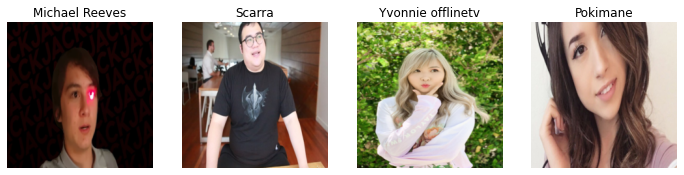

In [ ]:
dls.valid.show_batch(max_n = 4, nrows = 1)

We've got their faces (sort-of?), so we should be fine to continue. 

We'll use with resnet50 as our architecture and do 15 epochs. With such little data and this many epochs, we may lead to overfitting, but it could be okay, since we just need our model to memorize their faces. 

In [ ]:
learn = cnn_learner(dls, resnet50, metrics = error_rate)
learn.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,time
0,2.895511,2.695379,0.782609,00:03


epoch,train_loss,valid_loss,error_rate,time
0,2.480344,2.860579,0.826087,00:03
1,2.023533,3.023501,0.826087,00:03
2,1.819966,2.827506,0.782609,00:03
3,1.556158,2.574394,0.739130,00:03
4,1.353891,1.894838,0.608696,00:03
5,1.138215,1.408810,0.565217,00:03
6,0.980161,1.045331,0.521739,00:03
7,0.852521,0.737073,0.347826,00:03
8,0.753089,0.513677,0.173913,00:03
9,0.676120,0.356841,0.086957,00:03


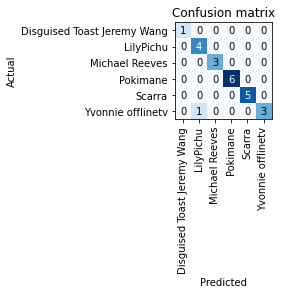

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The confusion matrix is mostly diagonal, but some of a couple are being wrongly predicted. 

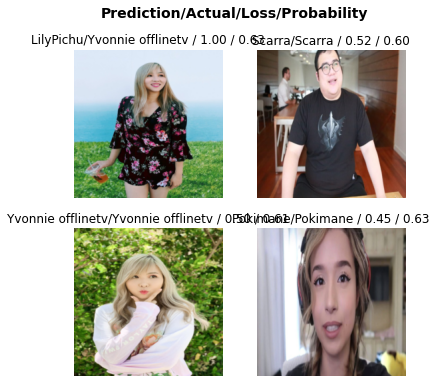

In [ ]:
interp.plot_top_losses(4, nrows = 2)

After a large number of reruns, I think we finally got a suitable model. We can export it and create an application for it.

You can find the application here.

In [ ]:
#hide 
path = Path()
learn.export()

In [ ]:
#hide
from google.colab import files
files.download('export.pkl')

In [ ]:
#hide
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
for i in cleaner.delete(): cleaner.fns[i].unlink()
for i,c in cleaner.change(): shutil.move(str(cleaner.fns[i]), path/c)